# Converts GPS positions to shape points

This notebook provides a simple projection and triangulation method to convert a list of GPS positions (lat, long) to points in the Californian image plane used in the GAMA california environment. We use two frames of reference to ensure better precision: a north frame and a south frame. This is a first version, the positions are approximate and may be incorrect sometimes.

### Libraries

In [14]:
from math import pi,sqrt,sin,cos,atan2
import numpy as np
import math
import shapefile
import matplotlib.pyplot as plt
import copy
import cv2
import matplotlib

### Constants


In [15]:
KM_CONVERT = 6367 # conversion ratio to km (approximate)
MILES_CONVERT = 3956 # conversion ratio to miles (approximate)
IMG_RATIO = 470 # image reduction ratio compared to real california (approximate)

### Functions

In [16]:
def haversine(pos1, pos2):
    """Computes the distance between two GPS positions.
    
    Args:
        pos1: the first GPS position, as float tuple (lat, long)
        pos2: the second GPS position, as float tuple (lat, long)
    Returns:
        a dict containing the distance between pos1 and pos2 in km and miles.

    """
    lat1 = float(pos1[0])
    long1 = float(pos1[1])
    lat2 = float(pos2[0])
    long2 = float(pos2[1])
    degree_to_rad = float(pi / 180.0)
    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad
    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    km = KM_CONVERT * c 
    mi = MILES_CONVERT * c 
    return {"km":km, "miles":mi}

def euclidean_dist(pa, pb):
    """Computes the euclidean distance between two 2D points.
    
    Args:
        pa: the first point, as float or int tuple (x, y)
        pb: the first point, as float or int tuple (x, y)
    Returns:
        the distance between the two points as int

    """
    return int(math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2))

def projection(gps_ref1, img_ref1, gps_ref2, img_ref2, gps_target):
    """Returns the distance in km between a GPS target position and two reference points
    
    Args:
        gps_ref1: the first reference point GPS position
        img_ref1: the first reference point image position
        gps_ref2: the second reference point GPS position
        img_ref2: the second reference point image position
        gps_tardet : the GPS position of the target point to projet
    Returns:
        the distance bewteen reference 1 and GPS target, and between reference 2 and GPS target, as float tuple.

    """
    km_per_px = haversine(gps_ref1, gps_ref2)["km"] / euclidean_dist(img_ref1, img_ref2)

    dist_1t = haversine(gps_ref1, gps_target)["km"]/km_per_px 
    dist_2t = haversine(gps_ref2, gps_target)["km"]/km_per_px 
    return (dist_1t,dist_2t)

def triangulation(referential, distances):
    """Triangulate the position of a point based on its distance to reference points and the reference points.
    
    Args:
        referential: the reference points, as tuple of int tuple
        distances: the distance to reference points, as float tuple
    Returns:
        the possible positions of the point (two possible solutions), as list of float tuple

    """
    x = (referential[0][0],referential[1][0]) # circles x coordinates
    y = (referential[0][1],referential[1][1]) # circles y coordinates
    R0 = distances[0] # first circle radius
    R1 = distances[1] # second circle radius

    # convert the circle intersection problem as a polynomial equation
    N = (R1**2-R0**2-x[1]**2+x[0]**2-y[1]**2+y[0]**2)/(2*(y[0]-y[1]))
    k = ((x[0]-x[1])/(y[0]-y[1]))
    A = k**2+1
    B = 2*y[0]*k - 2*N*k - 2*x[0]
    C = x[0]**2 + y[0]**2 + N**2 - R0**2 -2*y[0]*N

    # find the possible solutions (circle intersections)
    delta = sqrt(B**2-4*A*C)
    x_1 = (-B-delta)/(2*A)
    x_2 = (-B+delta)/(2*A)
    y_1 = N - x_1*k
    y_2 = N - x_2*k

    return [(x_1, y_1), (x_2, y_2)] # return the possible solutions (2 points)

def is_in_bounds(upper_bounds, lower_bounds, value):
    """Checks if a value is between upper and lower bounds.
    
    Args:
        upper_bounds: list of upper bounds 
        lower_bounds: list of lower bounds 
    Returns:
        True if the value is in bounds, else False

    """
    lb_ok = np.any(np.array(lower_bounds) <= value)
    ub_ok = np.any(np.array(upper_bounds) >= value)
    return lb_ok and ub_ok

### Setup

In [17]:
# By default, DO NOT TOUCH if you are not sure. Setup the reference points (image points and corresponding GPS 
# values), they are specific to the Californian image plan used to place the points.
img_point_A = (51,2) # north west fronteer limit
gps_A = (41.998447,-124.212000)
img_point_B = (763,21) # north east fronteer limit
gps_B = (41.994539,-119.999169)
img_point_D = (1311, 2196) # south west fronteer limit
gps_D = (32.534400, -117.123762)
img_point_E = (1771, 2136) # south east fronteer limit (before  the native american reserve)
gps_E = (32.747142, -114.702361)    

In [18]:
# get the y bounds on the image (california fronteers)
lower_bounds= [img_point_A[1], img_point_B[1]] # north fronteer y-axis (y=0 is north)
upper_bounds= [img_point_D[1], img_point_E[1]] # south fronteer y-axis

### Input

In [20]:
# gps points to project on the california 2D map
gps_targets = [(38.998638, -120.005673)] # example GPS point : middle-east fronteer angle in South Lake Tahoe
points_names = ["Lake Tahoe"] # corresponding names (for shapefile export)

### Main

In [21]:
# main code, project all the gps points on gps_target list on the california image plan
obtained_points = []
for gps_C in gps_targets:
    # compute distances from gps target points and image reference points
    dist_ac, dist_bc = projection(gps_A, img_point_A, gps_B, img_point_B, gps_C)
    dist_dc, dist_ec = projection(gps_D, img_point_D, gps_E, img_point_E, gps_C)

    # choose the closer referential
    referential = (img_point_A,img_point_B) # set referential A-B by default
    distances = (dist_ac, dist_bc )
    if(min(dist_dc, dist_ec) < min(dist_ac,dist_bc)): # if the D-E referential is closer
        referential = (img_point_D,img_point_E) # set referential D-E
        distances = (dist_dc, dist_ec) 
        
    # compute the possible projections of gps target point in the image plan
    res = triangulation(referential, distances) 
    
    solution = res[0] # by default, solution is the first point
    if not is_in_bounds(upper_bounds, lower_bounds, res[0][1]): # if first point is out of bounds
        solution = res[1] # solution is the second point
    
    final_point = [int(axis) for axis in solution] # truncate the point decimals (needing discrete axis)
    obtained_points.append(final_point) # store the obtained points

In [22]:
obtained_points # the resulting image points

[[760, 702]]

### Display the obtained points on the image

In [33]:
image = cv2.imread('calif_background.png') # load the california map image

In [34]:
color = (255,0,0)
h,w,_ = np.shape(image)
square_side = 20 # must be pair
for point in obtained_points:
    for i in range(-square_side//2,square_side//2):
        for j in range(-square_side//2,square_side//2):       
            image[min(point[1]+i,h-1),min(point[0]+j,w-1)] = color # put a colot square on the image

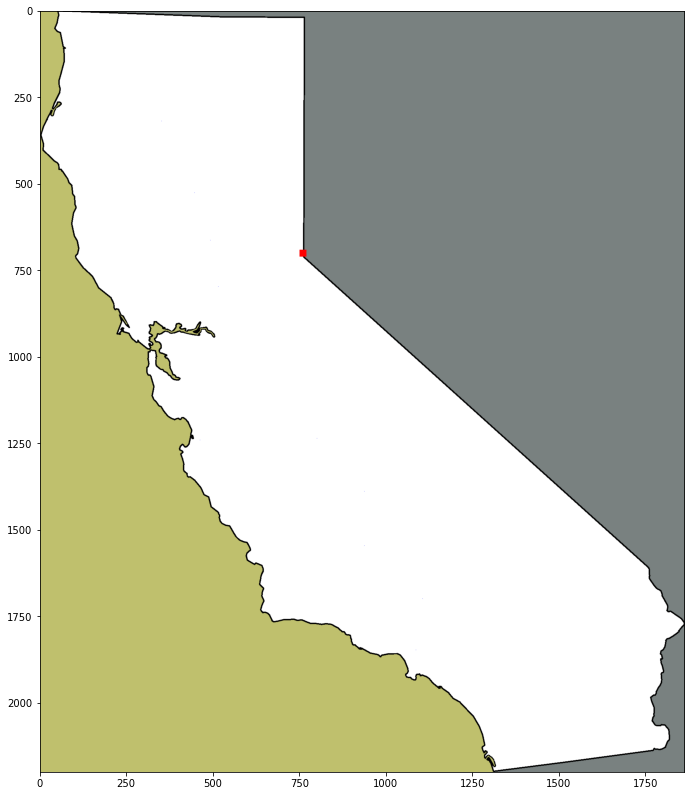

In [35]:
plt.figure(figsize=(14,14))
plt.imshow(image)

### Output : export the points in a shapefile

In [27]:
out_sph_filename = "my_points" # output shapefile name (for sph, dbf and shx files)

In [31]:
# write the obtained points in a shapefile (and its corresponding dbf and shx files)
with shapefile.Writer(out_sph_filename) as w: 
    w.field('NAME', 'C')
    for p,n in zip(obtained_points, points_names):
        w.point(p[0]*IMG_RATIO, -p[1]*IMG_RATIO) # save x and y coordinates
        w.record(n)

Note : the output files should be placed in the 'includes' repository of the GAMA california environment model. Then, the points can be loaded as agents this way :
```
global{
    [...] // the actual code
    file test_points <- file("../includes/my_points.shp");

    init{
        [...] // the actual code
        create MyAgent from: test_points with: [name:: read('NAME')];
    }
}

[...] // the actual code

species MyAgent  {
	string name;
	int shape_radius <- 5000; // 5000m circle displayed
    rgb color <- #black ;
    aspect base {
    	draw circle(shape_radius#m) color: color ;
    }
    
}
```